In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplfinance.original_flavor as mpf
from scipy.stats import linregress
import datetime
import seaborn

# 投資分析にのみ必要なモジュール
import mplfinance.original_flavor as mpf
from   oandapyV20 import API
import oandapyV20.endpoints.instruments as oandapy

In [117]:
df = pd.read_csv('stock_data/data/7739-キヤノン電子.csv', index_col=0)
df.head()

,日付,始値,高値,安値,終値,出来高,終値調整
0,2018-01-04,2500.0,2514.0,2480.0,2514.0,98400.0,2514.0
1,2018-01-05,2503.0,2548.0,2503.0,2545.0,63000.0,2545.0
2,2018-01-09,2555.0,2591.0,2551.0,2586.0,106700.0,2586.0
3,2018-01-10,2565.0,2571.0,2538.0,2541.0,61100.0,2541.0
4,2018-01-11,2532.0,2539.0,2518.0,2525.0,72400.0,2525.0


In [119]:
df = df.drop(['出来高', '終値調整'], axis = 1)
df.columns = ['date', 'open', 'high', 'low', 'close']
df.head()

,date,open,high,low,close
0,2018-01-04,2500.0,2514.0,2480.0,2514.0
1,2018-01-05,2503.0,2548.0,2503.0,2545.0
2,2018-01-09,2555.0,2591.0,2551.0,2586.0
3,2018-01-10,2565.0,2571.0,2538.0,2541.0
4,2018-01-11,2532.0,2539.0,2518.0,2525.0


# plotly.graph_objectで描画

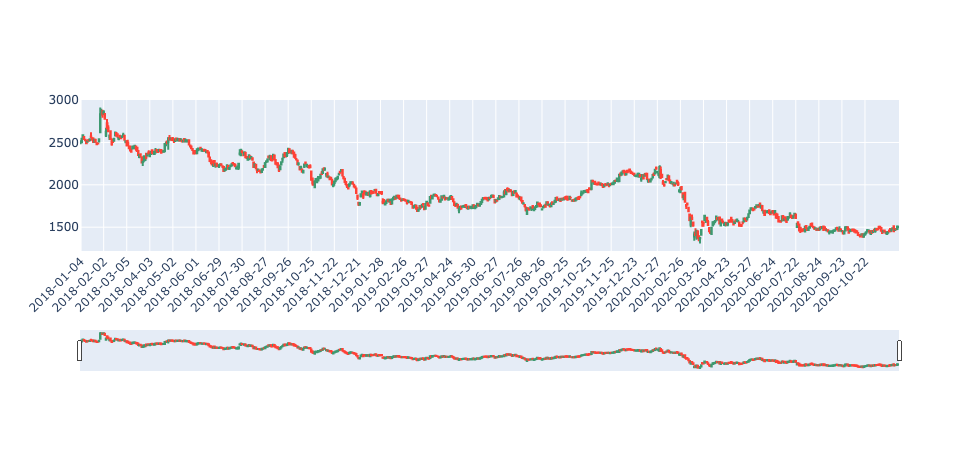

In [121]:
x = np.arange(len(df['date']))

interval = 20
#vals = [df.index[i*interval] for i in range(len(df)//interval+1)]
#labels = [df.loc[i*interval,'date'] for i in range(len(df)//interval +1)]
vals = [df.index[i*interval] for i in range(len(df)//interval)]
labels = [df.loc[i*interval,'date'] for i in range(len(df)//interval)]

fig = go.Figure(
        data=go.Candlestick(
                x = x,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                hovertext= ['date:{}<br>open:{}<br>high:{}<br>low:{}<br>close:{}'
                                   .format(df.loc[i,'date'],df.loc[i,'open'],df.loc[i,'high'],df.loc[i,'low'],df.loc[i,'close']) for i in range(len(df))] ,
                hoverinfo="text"),
        layout = go.Layout(
                xaxis = dict(
                    ticktext = labels,
                    tickvals = vals,
                    tickangle=-45
                ),
        )
)
fig.show()

# matplotlib.pyplotでトレンドラインを引く  

In [127]:
#df = pd.read_csv('stock_data/data/9984-ソフトバンクグループ.csv', index_col=0)
#df = pd.read_csv('stock_data/data/9202-ＡＮＡホールディングス.csv', index_col=0)
df = pd.read_csv('stock_data/data/7739-キヤノン電子.csv', index_col=0)
df = df.drop(['出来高', '終値調整'], axis = 1)
df.head()

,日付,始値,高値,安値,終値
0,2018-01-04,2500.0,2514.0,2480.0,2514.0
1,2018-01-05,2503.0,2548.0,2503.0,2545.0
2,2018-01-09,2555.0,2591.0,2551.0,2586.0
3,2018-01-10,2565.0,2571.0,2538.0,2541.0
4,2018-01-11,2532.0,2539.0,2518.0,2525.0


In [128]:
class FXBase():
    candles = None
    def __init__(self):
        cols = ['col1', 'col2']
        FXBase.candles = pd.DataFrame(index=[], columns=cols)

In [129]:
FXBase.candles = df
FXBase.candles.columns = ['time', 'open', 'high', 'low', 'close']
FXBase.candles['time_id']= FXBase.candles.index + 1
FXBase.candles.head()

,time,open,high,low,close,time_id
0,2018-01-04,2500.0,2514.0,2480.0,2514.0,1
1,2018-01-05,2503.0,2548.0,2503.0,2545.0,2
2,2018-01-09,2555.0,2591.0,2551.0,2586.0,3
3,2018-01-10,2565.0,2571.0,2538.0,2541.0,4
4,2018-01-11,2532.0,2539.0,2518.0,2525.0,5


In [130]:
# トレンドラインを引く
## チャートを単回帰分析し

# 高値の始点/支点を取得
def get_highpoint(start, end):
    chart = FXBase.candles[start:end+1]
    while len(chart)>3:
        regression = linregress(
            x = chart['time_id'],
            y = chart['high'],
        )
        chart = chart.loc[chart['high'] > regression[0] * chart['time_id'] + regression[1]]
    return chart

# 安値の始点/支点を取得
def get_lowpoint(start, end):
    chart = FXBase.candles[start:end+1]
    while len(chart)>3:
        regression = linregress(
            x = chart['time_id'],
            y = chart['low'],
        )
        chart = chart.loc[chart['low'] < regression[0] * chart['time_id'] + regression[1]]
    return chart

def g_trendlines(span=20, min_interval=3):
    trendlines = []

    # 高値の下降トレンドラインを生成
    #for i in FXBase.candles.index[::span/2]:
    for i in FXBase.candles.index[::span//2]:
        highpoint = get_highpoint(i, i + span)
        # ポイントが2箇所未満だとエラーになるので回避する
        if len(highpoint) < 2:
            continue
        # 始点と支点が近過ぎたらトレンドラインとして引かない
        if abs(highpoint.index[0] - highpoint.index[1]) < min_interval:
            continue
        regression = linregress(
            x = highpoint['time_id'],
            y = highpoint['high'],
        )
        #print(regression[0] < 0.0, 'reg_high: ', regression[0], ', ', regression[1], )

        # 下降してるときだけ
        if regression[0] < 0.0:
            trendlines.append(regression[0] * FXBase.candles['time_id'][i:i+span*2] + regression[1])

    # 安値の上昇トレンドラインを生成
    #for i in FXBase.candles.index[::span/2]:
    for i in FXBase.candles.index[::span//2]:
        lowpoint   = get_lowpoint(i, i + span)
        # ポイントが2箇所未満だとエラーになるので回避する
        if len(lowpoint) < 2:
            continue
        # 始点と支点が近過ぎたらトレンドラインとして引かない
        if abs(lowpoint.index[0] - lowpoint.index[1]) < min_interval:
            continue
        regression = linregress(
            x = lowpoint['time_id'],
            y = lowpoint['low'],
        )
        #print(regression[0] > 0.0, 'reg_low: ', regression[0], ', ', regression[1], )

        # 上昇してるときだけ
        if regression[0] > 0.0:
            trendlines.append(regression[0] * FXBase.candles['time_id'][i:i+span*2] + regression[1])

    return trendlines

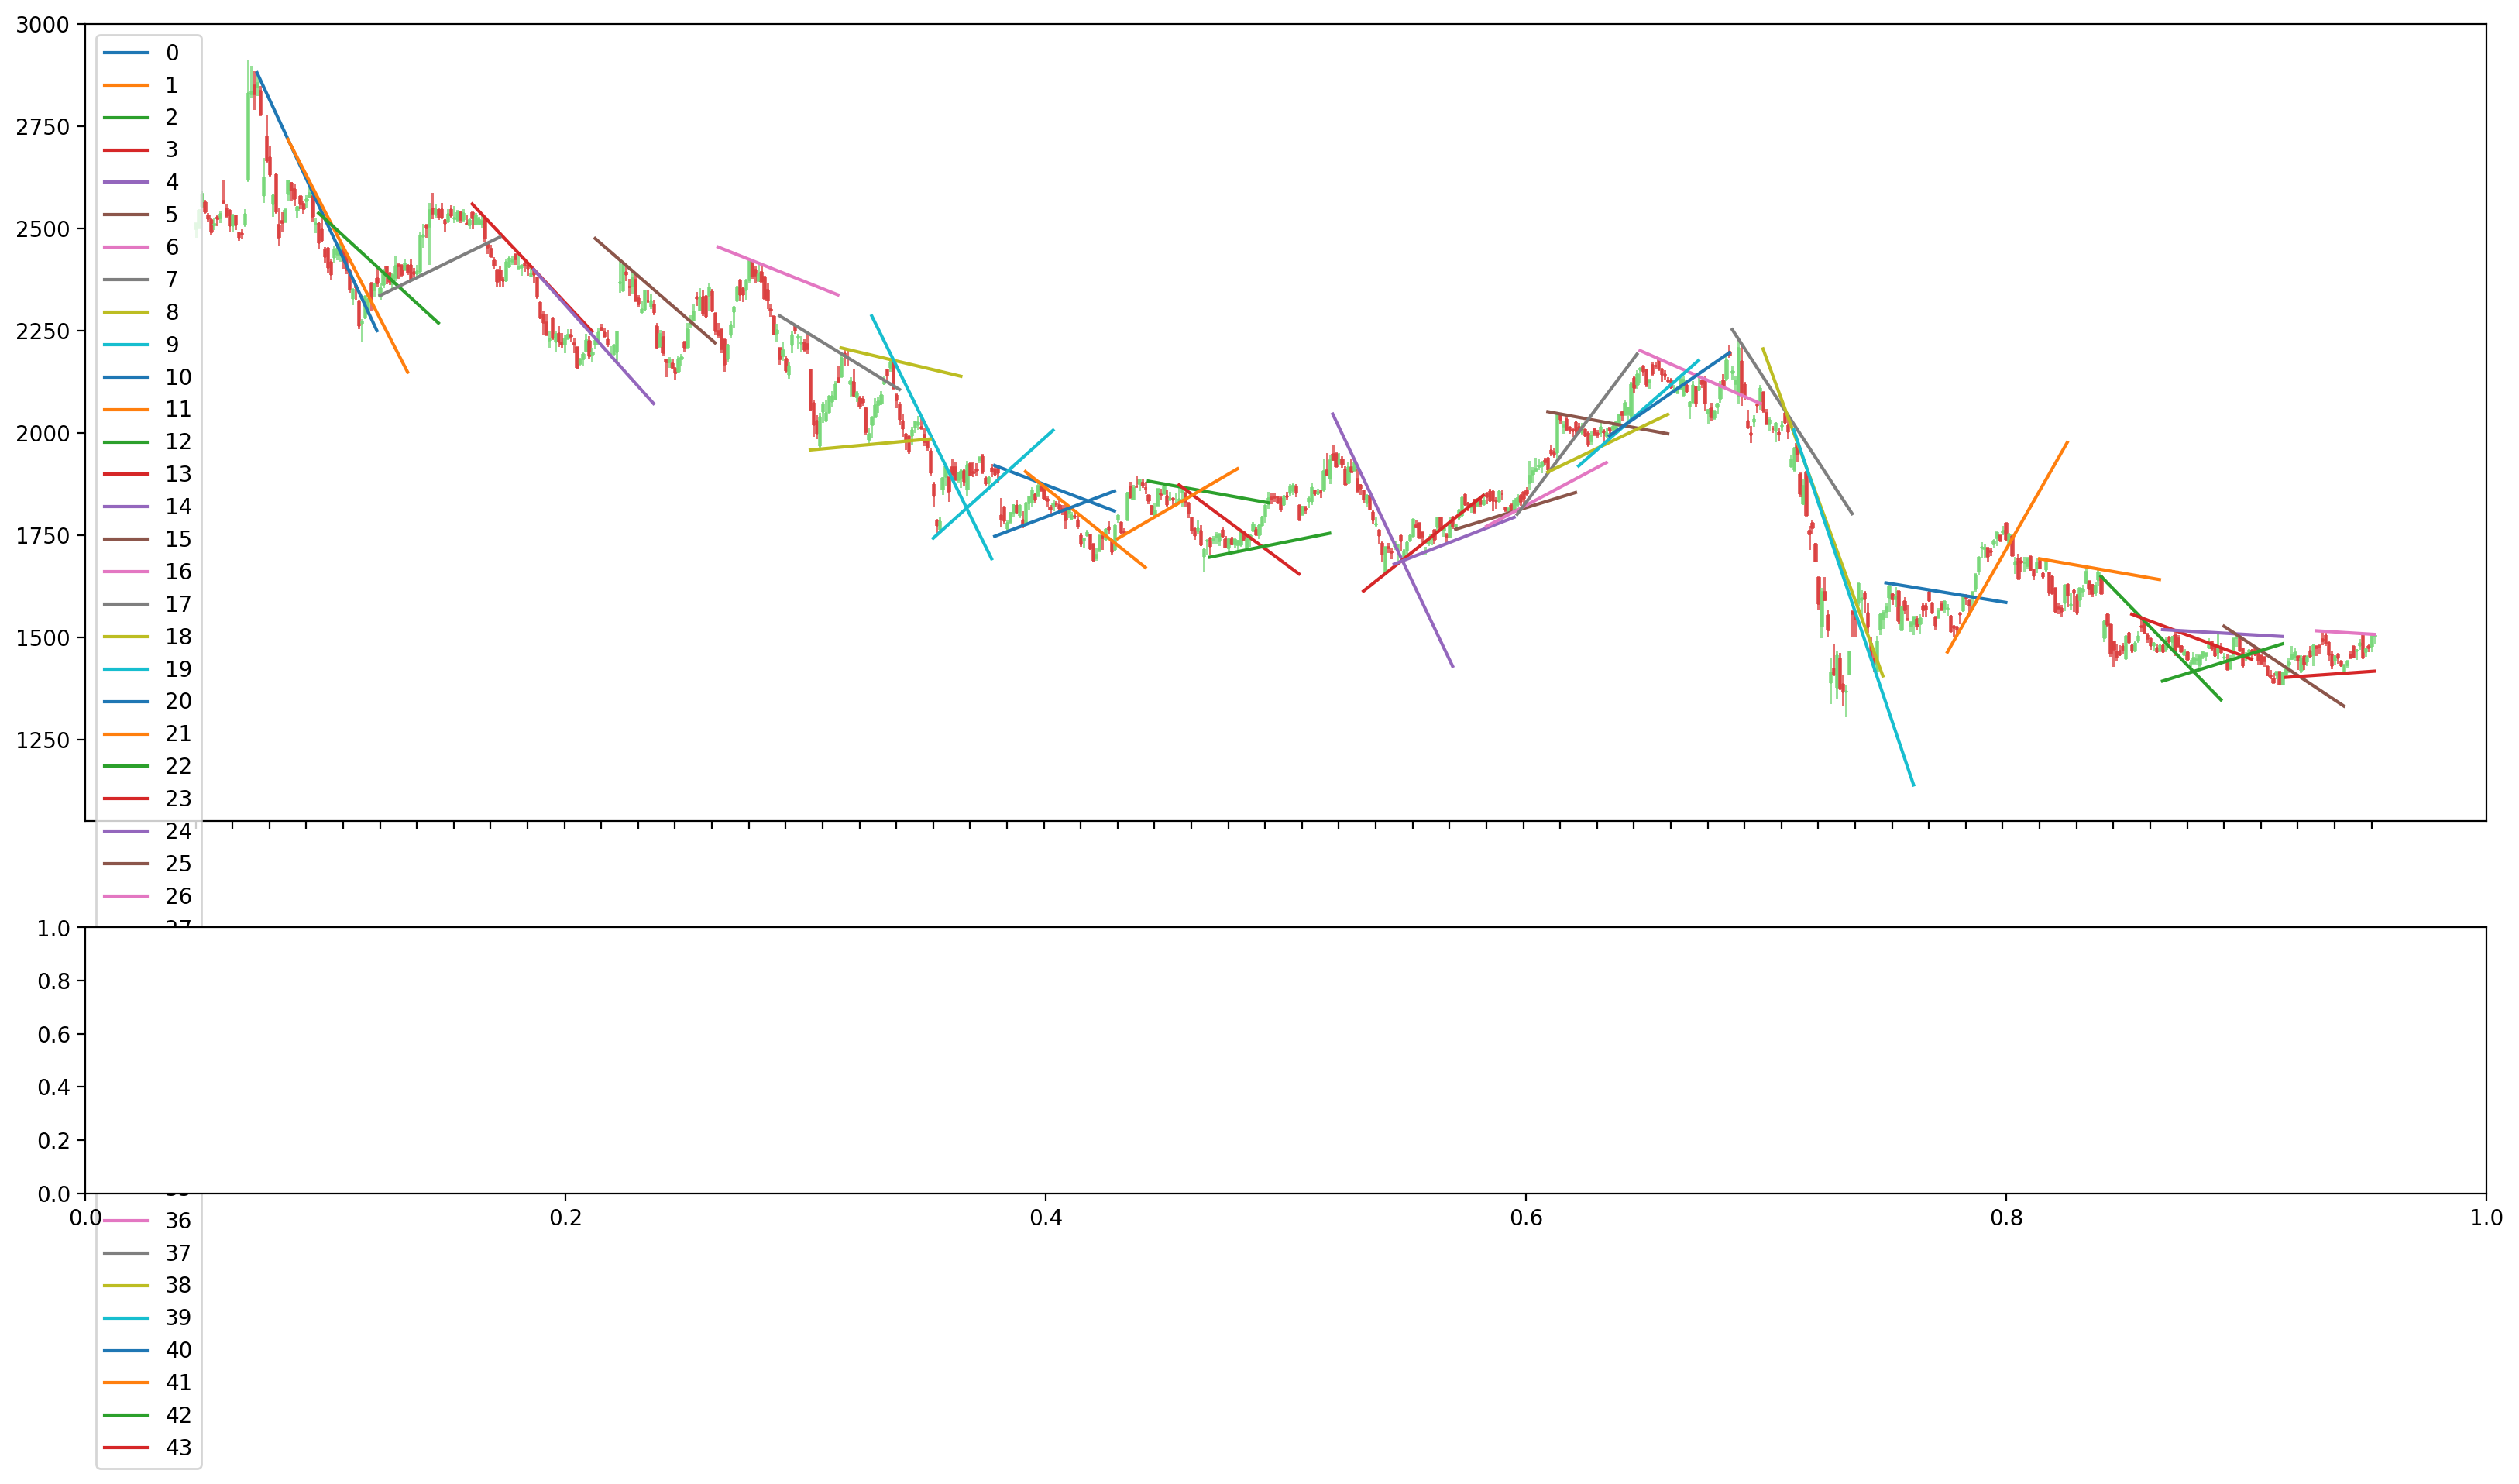

In [131]:
figure, (axis1, axis2) = plt.subplots(2, 1, figsize=(20,10), dpi=200, gridspec_kw = {'height_ratios':[3, 1]})

# ローソク足
mpf.candlestick2_ohlc(
    axis1,
    opens  = FXBase.candles.open.values,
    highs  = FXBase.candles.high.values,
    lows   = FXBase.candles.low.values,
    closes = FXBase.candles.close.values,
    width=0.6, colorup='#77d879', colordown='#db3f3f'
)

# トレンドラインたちを引く
for i, line in enumerate(g_trendlines()):
    axis1.plot(line, label=i)

# X軸の見た目を整える
xticks_number  = 12 # 12本刻みに目盛りを書く
xticks_index   = range(0, len(FXBase.candles), xticks_number)
xticks_display = [FXBase.candles.time.values[i][11:16] for i in xticks_index] # 時間を切り出すため、先頭12文字目から取る

# axis1を装飾 ( plt.sca(axis): set current axis )
plt.sca(axis1)
plt.xticks( xticks_index, xticks_display )
plt.legend()
plt.show()

In [1]:
#end